In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from Scratch import metadata_loader
import numpy as np
from tqdm import tqdm

DEVICE = "ibm_sherbrooke"
LOGICAL = str(0)
XBASIS = False
ROUNDS = 10

state = "X" if XBASIS else "Z"
state += LOGICAL
print(f"state = {state}")


# Load the metadata
md = metadata_loader(True, True)
md = md[md["job_status"] == "JobStatus.DONE"]
md = md[md["code"] == "RepetitionCodeCircuit"]
md = md[md["descr"] == 'subset RepCodes']
md = md.dropna(subset=["rounds"])
md = md[md["meas_level"] == 1]
md['rounds'] = md['rounds'].astype(int)
md['distance'] = md['distance'].astype(int)

md = md[md["backend_name"] == DEVICE]
md = md[md["logical"] == LOGICAL]
md = md[md["xbasis"] == XBASIS]
md = md[md["rounds"] == ROUNDS]

md = md[md['notebook_name']=='Sherbrooke_RepCodes_jobs']

# md = md[0:1]
print("shape:", md.shape)
md[:2]


state = Z0
shape: (40, 18)


,creation_date,notebook_name,backend_name,job_id,tags,meas_level,shots,num_qubits,job_status,execution_date,code,distance,rounds,logical,descr,resets,xbasis,path_info
4246,2024-03-23 09:24:23.431000+01:00,Sherbrooke_RepCodes_jobs,ibm_sherbrooke,cqz93dxs9z7g008dny3g,"[Subset 52, 10 rounds, 0 log, xbasis=False]",1.0,6525.0,NaN,JobStatus.DONE,2024-03-23 10:20:19.544059+01:00,RepetitionCodeCircuit,52,10,0,subset RepCodes,NaN,False,"{'mean_gate_error': 0.007733045348037, 'min_ga..."
4245,2024-03-23 09:24:20.868000+01:00,Sherbrooke_RepCodes_jobs,ibm_sherbrooke,cqz93d5czq6g0081h1vg,"[Subset 52, 10 rounds, 0 log, xbasis=False]",1.0,6525.0,NaN,JobStatus.DONE,2024-03-23 10:19:41.529823+01:00,RepetitionCodeCircuit,52,10,0,subset RepCodes,NaN,False,"{'mean_gate_error': 0.007733045348037, 'min_ga..."


In [3]:
from result_saver import SaverProvider

provider = SaverProvider()

In [4]:
md_loc = 0

job_id = md.iloc[md_loc]["job_id"]
job = provider.retrieve_job(job_id) 

execution_date = job.result().date
memory = job.result().get_memory()

print(f"Execution date: {execution_date}")

Execution date: 2024-03-23 10:20:19.544059+01:00


In [5]:
assert md_loc == 0
for id in range(1, 5):
    job = provider.retrieve_job(md.iloc[id]["job_id"])
    memory = np.vstack([memory, job.result().get_memory()])

In [6]:
from soft_info import inv_qubit_mapping, get_repcode_IQ_map

_RESETS = False
SOFT_MUL = 0.5
T = md.iloc[md_loc]["rounds"]
d = md.iloc[md_loc]["distance"]

shots = md.iloc[md_loc]["shots"]
# Get the layout of the last job (same as previous)
layout_des = job.deserialize_layout(job.initial_layouts()[0]) # only 1 layout
link_qubits = list(layout_des['link_qubit'].values())
code_qubits = list(layout_des['code_qubit'].values())

# Get the pSoft and countMat matrices
big_layout = link_qubits + code_qubits
inverted_q_map = inv_qubit_mapping(get_repcode_IQ_map(big_layout, synd_rounds=T))

# GMM fitting

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

def fit_and_plot_gmm(data, n_components_range=[2, 3], covariance_type='full'):
    # Flatten the data if it is complex
    real_parts = np.real(data).flatten()
    imag_parts = np.imag(data).flatten()
    X = np.column_stack([real_parts, imag_parts])

    # Fit GMMs with 2 and 3 components
    lowest_bic = np.infty
    bic = []
    best_gmm = None
    for n_components in n_components_range:
        if n_components == 2:
            weights_init = np.array([0.5, 0.5])
            gmm = GaussianMixture(n_components=n_components, covariance_type='tied', weights_init=weights_init)
        if n_components == 3:
            weights_init = np.array([0.47, 0.47, 0.06])
            gmm = GaussianMixture(n_components=n_components, covariance_type='full', weights_init=weights_init)
        else:
            gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

    # Plot the data
    plt.figure(figsize=(4, 4))
    plt.scatter(real_parts, imag_parts, s=0.5)

    # Plot the GMM components
    ax = plt.gca()
    for mean, cov in zip(best_gmm.means_, best_gmm.covariances_):
        v, w = np.linalg.eigh(cov)
        v = 2. * np.sqrt(2.) * np.sqrt(v)  # 2*sqrt(2) scales to 1 std
        u = w[0] / np.linalg.norm(w[0])
        # Plot an ellipse to show the Gaussian component
        angle = np.arctan2(u[1], u[0])
        angle = np.degrees(angle)  # Convert to degrees
        ell = Ellipse(mean, v[0], v[1], angle=angle, edgecolor='r', facecolor='none')
        ax.add_artist(ell)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)

    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.title('Gaussian Mixture Model Fit')
    plt.show()

    return best_gmm


import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

def fit_and_plot_gmm_with_classifications(data, n_components_range=[2, 3], covariance_type='full'):
    # Flatten the data if it is complex
    real_parts = np.real(data).flatten()
    imag_parts = np.imag(data).flatten()
    X = np.column_stack([real_parts, imag_parts])

    # Fit GMMs with 2 and 3 components
    lowest_bic = np.infty
    bic = []
    best_gmm = None
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, means_init=np.array([[-1e10, 0], [+1e10, 0], [1e10, 1e10]]))
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

    # Classify points
    predictions = best_gmm.predict(X)

    # Plot the data
    plt.figure(figsize=(4, 4))
    scatter = plt.scatter(real_parts, imag_parts, s=0.5, c=predictions, cmap='viridis')

    # Create a color bar
    plt.colorbar(scatter)

    # Plot the GMM components
    ax = plt.gca()
    for mean, cov in zip(best_gmm.means_, best_gmm.covariances_):
        v, w = np.linalg.eigh(cov)
        v = 2. * np.sqrt(2.) * np.sqrt(v)  # 2*sqrt(2) scales to 1 std
        u = w[0] / np.linalg.norm(w[0])
        # Plot an ellipse to show the Gaussian component
        angle = np.arctan2(u[1], u[0])
        angle = np.degrees(angle)  # Convert to degrees
        ell = Ellipse(mean, v[0], v[1], angle=angle, edgecolor='black', facecolor='none')
        ax.add_artist(ell)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)

    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.title('Gaussian Mixture Model Fit with Classifications')
    plt.show()

    return best_gmm

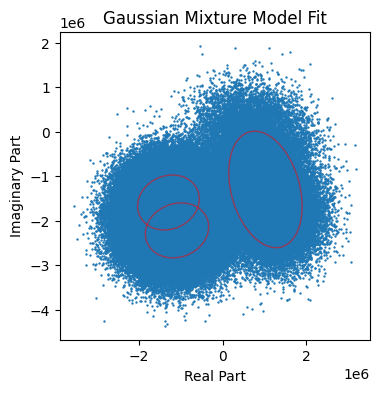

[0.43218572 0.44376032 0.12405396]


In [12]:
qubit = 9
cols = inverted_q_map[qubit]

data = memory[:, cols]



gmm = fit_and_plot_gmm(data, n_components_range=[3], covariance_type='full')
print(gmm.weights_)
# gmm = fit_and_plot_gmm_with_classifications(data, n_components_range=[3], covariance_type='full')